In [1]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import matplotlib
from pm_func_edr3 import *

In [2]:
num = "2"
model = Table.read("Data/allstar_Model"+num+".fits")

print("Number of Model " + num + " stars is " + str(len(model)))

plotc = "tomato"  #tomato, royalblue, violet
#relc = "darkred"
#rvc = "forestgreen"

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

print(model.info())

Number of Model 2 stars is 233384
<Table length=233384>
 name  dtype 
----- -------
  Age float64
  X_0 float64
  Y_0 float64
  Z_0 float64
 Vx_0 float64
 Vy_0 float64
 Vz_0 float64
  X_G float64
  Y_G float64
  Z_G float64
 Vx_G float64
 Vy_G float64
 Vz_G float64
   RA float64
  DEC float64
 Dist float64
 PMRA float64
PMDEC float64
   RV float64
None


In [3]:
#### Because this is sim data, it hasn't gone through other cuts, so I need to calculate x/y values

ra0 = np.deg2rad(13.038)
dec0 = np.deg2rad(-73.094)

center = np.asarray([ra0, dec0])

tempx, tempy = wcs2gaiaxy(np.deg2rad(model['RA']), np.deg2rad(model['DEC']), center)

## Add the cartesian coordinates as new columns to the catalog

tempx.shape = (len(tempx),)
tempy.shape = (len(tempy),)

model.add_column(tempx, name="x")
model.add_column(tempy, name="y")

In [4]:
####
   # Set plotting bounds for the position and proper motion plots
####

displayvals = []

xmin, xmax, ymin, ymax = -10.0, 10.0, -10.0, 10.0

displayvals.append(xmin)
displayvals.append(xmax)
displayvals.append(ymin)
displayvals.append(ymax)

pmramin, pmramax, pmdecmin, pmdecmax, rvmin, rvmax = -1.5, 3.0, -3.5, 1.5, 50.0, 250.0

displayvals.append(pmramin)
displayvals.append(pmramax)
displayvals.append(pmdecmin)
displayvals.append(pmdecmax)
displayvals.append(rvmin)
displayvals.append(rvmax)


## Set bin widths

xwidth, ywidth = 0.4, 0.4 #0.2, 0.2

displayvals.append(xwidth)
displayvals.append(ywidth)


##

yaxis = np.asarray([[0.0, -8.0, 0.0], [0, 8.0, 0.0]])
xaxis = np.asarray([[-8.0, 0.0, 0.0], [8.0, 0.0, 0.0]])

tempcos = np.dot(yaxis[0], xaxis[0]) / (np.linalg.norm(yaxis[0])*np.linalg.norm(xaxis[0]))

#print np.rad2deg(np.arccos(tempcos))

axisrot = np.deg2rad(55.0)

newyaxis = rot3d(yaxis[:,0], yaxis[:,1], yaxis[:,2], rot_zaxis(axisrot))
newxaxis = rot3d(xaxis[:,0], xaxis[:,1], xaxis[:,2], rot_zaxis(axisrot))


tempcos2 = np.dot(newyaxis[0], newxaxis[0]) / (np.linalg.norm(newyaxis[0])*np.linalg.norm(newxaxis[0]))


## For the sake of plotting, trim the data set down to only include stars in the x/y lims

model = model[(model['x'] < xmax) & (model['x'] > xmin) & (model['y'] < ymax) & (model['y'] > ymin)]

[[ 9.04874065e-01  2.96593258e+00  0.00000000e+00]
 [ 8.54735573e-01  2.91570511e+00  0.00000000e+00]
 [ 1.09619352e+00  2.86278147e+00 -7.10542736e-15]
 ...
 [ 5.20058600e-01 -2.92183280e-01 -7.10542736e-15]
 [ 5.42068641e-01 -2.99292110e-01  7.10542736e-15]
 [ 5.30996113e-01 -3.30083824e-01  0.00000000e+00]]
1.0 0.0 6.123233995736766e-17


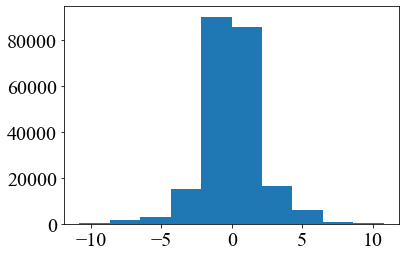

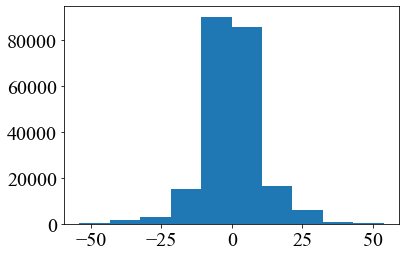

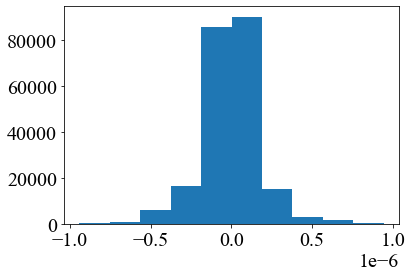

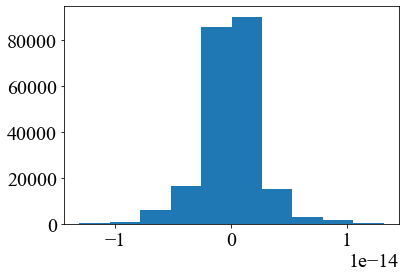

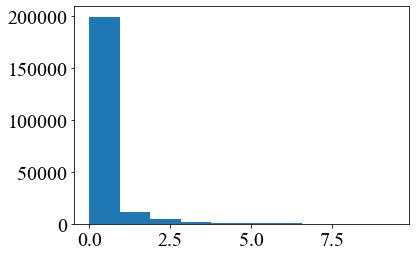

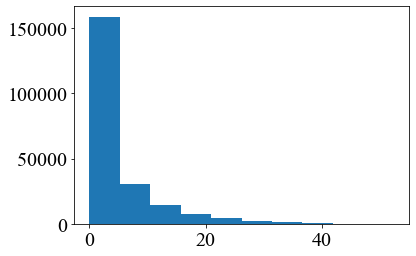

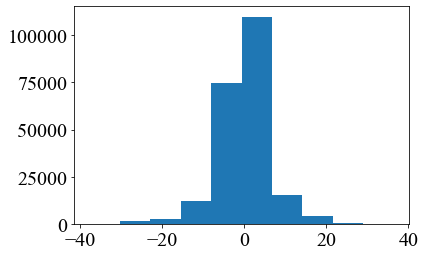

In [5]:
modelver = "cm+tidal"

incl = np.deg2rad(0.000001)
theta = np.deg2rad(0.000001)
muE0 = 0.68         #Center of mass proper motion east in mas/yr
muN0 = -1.23         #CM proper motion north	in mas/yr
vsys = 148.0          #CM radial velocity in km/s
m_M = 18.91

dist0 = (10**((m_M/5.0)+1)) / 1000.0      #distance in kpc to the galaxy center


rad0 = 0.00001
rotvel0 = 0.0

phi_tid = np.deg2rad(0.0)
theta_tid = np.deg2rad(90.0)
v_tid = 5.0



vtran, thtran = calc_transverse(muE0, muN0, dist0)

rho, phi = wcs2ang(ra0, dec0, np.deg2rad(model['RA']), np.deg2rad(model['DEC']))

dist = calc_dist(rho, phi, dist0, incl=incl, theta=theta)

v1_cm, v2_cm, c3_cm = make_cm_angvec(vtran, thtran, vsys, rho, phi)


##

newcoord = ang2xyz(rho, phi, dist, dist0, theta=theta, incl=incl)
xg, yg, zg = 0, 1, 2

print(newcoord)

vframe = np.zeros((len(rho),3))
vx, vy, vz = 0, 1, 2

xs_tid, ys_tid, zs_tid = sph_2_skyxyz(phi_tid, theta_tid, 1.0)

print(xs_tid, ys_tid, zs_tid)

##

xg_tid, yg_tid, zg_tid = skyxyz_2_galxyz(xs_tid, ys_tid, zs_tid, theta, incl)

dist_tid = xg_tid*newcoord[:,xg] + yg_tid*newcoord[:,yg] + zg_tid*newcoord[:,zg]

plt.clf()
plt.hist(dist_tid)
plt.show()

vframe[:,vx] = xg_tid * dist_tid * v_tid
vframe[:,vy] = yg_tid * dist_tid * v_tid
vframe[:,vz] = zg_tid * dist_tid * v_tid


plt.clf()
plt.hist(vframe[:,vx])
plt.show()

plt.clf()
plt.hist(vframe[:,vy])
plt.show()

plt.clf()
plt.hist(vframe[:,vz])
plt.show()

v1, v2, v3 = vel_xyz2sph(vframe, theta, incl, rho, phi)


plt.clf()
plt.hist(v1)
plt.show()

plt.clf()
plt.hist(v2)
plt.show()

plt.clf()
plt.hist(v3)
plt.show()

[[ 2.95630824e+00  2.51385207e+00  0.00000000e+00]
 [ 2.88358386e+00  2.52699653e+00  3.55271368e-15]
 [ 2.98302674e+00  2.05981745e+00  3.55271368e-15]
 ...
 [ 1.08639652e-01 -1.15305955e+00  0.00000000e+00]
 [ 1.17127568e-01 -1.19449244e+00  0.00000000e+00]
 [ 8.69195302e-02 -1.21633993e+00  0.00000000e+00]]


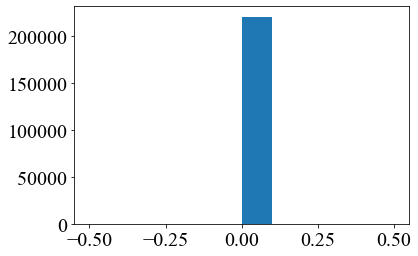

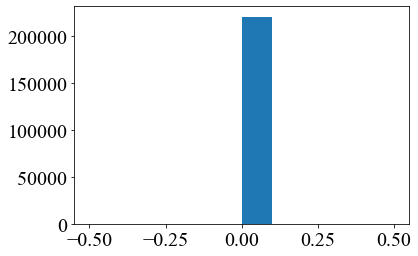

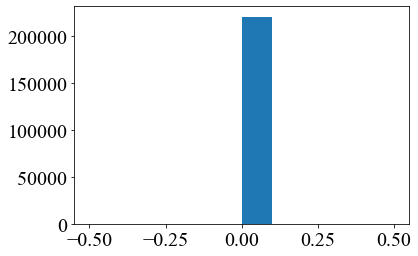

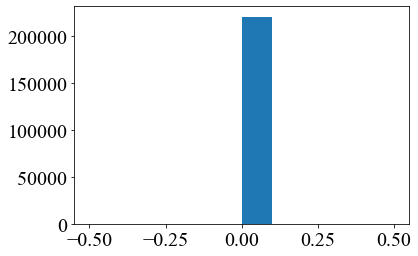

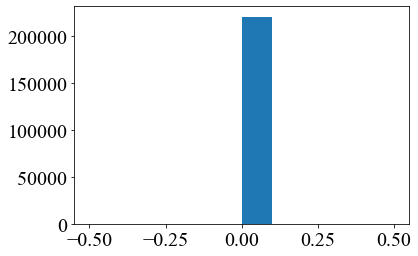

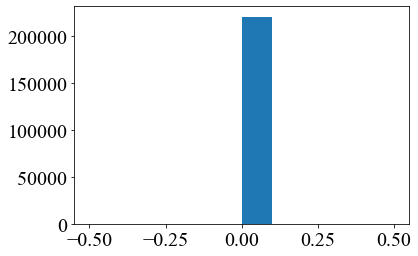

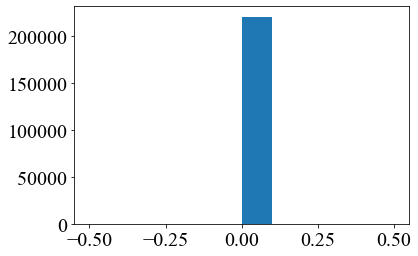

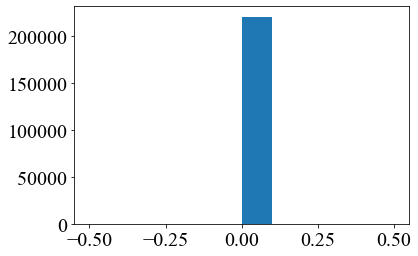

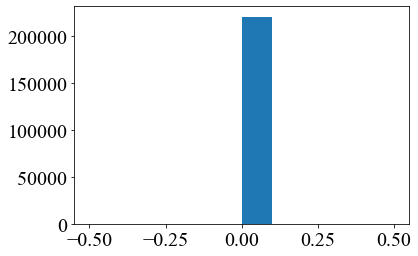

In [6]:
modelver = "cm+rot"

incl = np.deg2rad(60.000001)
theta = np.deg2rad(50.000001)
muE0 = 0.68         #Center of mass proper motion east in mas/yr
muN0 = -1.23         #CM proper motion north	in mas/yr
vsys = 148.0          #CM radial velocity in km/s
m_M = 18.91

dist0 = (10**((m_M/5.0)+1)) / 1000.0      #distance in kpc to the galaxy center


rad0 = 1.00001
rotvel0 = 0.0

phi_tid = np.deg2rad(0.0)
theta_tid = np.deg2rad(00.0)
v_tid = 0.0



vtran, thtran = calc_transverse(muE0, muN0, dist0)

rho, phi = wcs2ang(ra0, dec0, np.deg2rad(model['RA']), np.deg2rad(model['DEC']))

dist = calc_dist(rho, phi, dist0, incl=incl, theta=theta)

v1_cm, v2_cm, c3_cm = make_cm_angvec(vtran, thtran, vsys, rho, phi)


##

newcoord = ang2xyz(rho, phi, dist, dist0, theta=theta, incl=incl)
xg, yg, zg = 0, 1, 2

print(newcoord)

vframe = np.zeros((len(rho),3))
vx, vy, vz = 0, 1, 2


##

rotval = rotcurve(newcoord[:,xg], newcoord[:,yg], rad0, rotvel0)

rotval.shape = (len(rho),)


vframe[:,vx] = rotval * (newcoord[:,yg]/(newcoord[:,xg]**2 + newcoord[:,yg]**2)**(0.5))

vframe[:,vy] = -1.0 * rotval * (newcoord[:,xg]/(newcoord[:,xg]**2 + newcoord[:,yg]**2)**(0.5))

v1, v2, v3 = vel_xyz2sph(vframe, theta, incl, rho, phi)



plt.clf()
plt.hist(vframe[:,vx])
plt.show()

plt.clf()
plt.hist(vframe[:,vy])
plt.show()

plt.clf()
plt.hist(vframe[:,vz])
plt.show()


plt.clf()
plt.hist(v1)
plt.show()

plt.clf()
plt.hist(v2)
plt.show()

plt.clf()
plt.hist(v3)
plt.show()


v1_rot, v2_rot, v3_rot = make_int_angvec_plane(rad0, rotvel0, theta, incl, dist0, rho, phi, dist)

plt.clf()
plt.hist(v1_rot)
plt.show()

plt.clf()
plt.hist(v2_rot)
plt.show()

plt.clf()
plt.hist(v3_rot)
plt.show()